<a href="https://colab.research.google.com/github/beifa/kaggle_ashrae/blob/master/iwant_kMeans_kNN_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gc
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error

path = '/content/drive/My Drive/ASHRAE/data/'

In [0]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls '/content/drive/My Drive/ASHRAE/data/'

building_metadata.csv		droped_fetures_by_2.csv  test2.hdf5
data_test_before_fake.pkl	droped_fetures_by_3.csv  test_addTime.pkl.gz
data_test_ends.pkl.gz		droped_fetures_by_4.csv  train.csv
data_test.pkl.gz		droped_fetures_by_5.csv  train_full_fill.pkl.gz
data_train_add_features.pkl.gz	droped_fetures_by_6.csv  weather_test.csv
data_train_before_fake.pkl.gz	metadata_fillNAN.pkl.gz  weather_train.csv
droped_fetures_by_2_1.csv	sample_submission.csv


In [0]:
train = pd.read_pickle(path + 'data_train_add_features.pkl.gz')

In [0]:
def rand_sample(f = 0.25):
  #вернет выборку рандомную, f - коеф. размера выборки
  np.random.seed(0)
  idx = np.argsort(train.timestamp.values, kind='stable')
  sample_idx = np.random.choice(idx, int(len(idx) * f), replace=False)  
  return sample_idx

In [0]:
sample_train = train.iloc[rand_sample(f = 0.25)] #4584686 rows × 45 columns

In [0]:
del train
gc.collect()

0

#kMeans

In [0]:
sample_train.head(2)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,mark_not_fill_air_temperature,mark_not_fill_cloud_coverage,mark_not_fill_dew_temperature,mark_not_fill_precip_depth_1_hr,mark_not_fill_sea_level_pressure,mark_not_fill_wind_direction,mark_not_fill_wind_speed,hour,month,weekday,dayofyear,weekofyear,quarter,monthday,holiday,rolling_back_air_temperature,rolling_forw_air_temperature,rolling_back_h_air_temperature,rolling_back_h_f_air_temperature,rolling_back_dew_temperature,rolling_forw_dew_temperature,rolling_back_h_dew_temperature,rolling_back_h_f_dew_temperature,e,es,rh,rec_air,rec_dew,rec_rh
3269514,625,0,1471,173.737,4,0,55516,1978,5,21.1,2.0,8.3,0.0,1020.099976,300.0,3.1,1,1,1,1,1,1,1,7,2,2,61,8,0,1,0,34.400002,23.299999,15.0,18.299999,-1.7,5.0,-1.7,-0.6,24.975677,10.941831,43.809947,Good,Good,Good
18672345,661,0,8125,1.297,5,1,7427,1976,2,5.0,0.0,2.0,0.0,1016.400024,80.0,8.8,1,1,1,0,0,1,1,13,11,6,338,47,3,3,0,5.600000,11.100000,20.0,5.600000,-5.6,9.4,-0.6,4.4,8.720732,7.056989,80.921976,bad,Good,big_h


In [0]:
sample_train = sample_train.drop(['rec_air', 'rec_dew', 'rec_rh'], axis = 1)

In [0]:
def cluster_id(data, mark, model, num_cluster, skip = True):
  """
  че мы хотим, а мы хотим
  разбиваем на  сайт ид и в нем делаем кластеры
  затем учим и предсказывае для каждого кластера в сайт ид

  data = data
  num_clusters = int, num cluster  
  mark = feature test
  """
  df_id = pd.DataFrame(data = np.zeros(len(data)), columns = ['pred'], index=data.index)
  for id_ in data.site_id.unique():  
    mask_id = data.site_id == id_
    site_id = data.loc[mask_id]
    #we make cluster in site id
    if skip:    
      g = site_id.groupby(mark)['meter_reading'].median()
      km = KMeans(n_clusters=num_cluster, init='random', n_init=5, max_iter=100, random_state=13, n_jobs=-1)
      label = km.fit_predict(g.values.reshape(-1, 1))
      g = g.to_frame()
      g['labels'] = label
      cluster_df = site_id[mark].map(g['labels']) #i make idx - labels
      for num in range(num_cluster):
        #num clusters
        idx = cluster_df[cluster_df == num].index #index cluster in id_site
        idx_box[id_] = idx #index clusters onli site_id
        #site_id.loc[cluster_df[cluster_df == 1].index]
        X = site_id.loc[idx].drop('meter_reading', axis = 1)
        y = site_id.loc[idx]['meter_reading']
        # learning
        # predict for cluster
        # join for predict site
        # add for predict sample train       
        model.fit(X, y)        
        df_id.loc[idx, 'pred'] = model.predict(X)
    else:
      #print(id_)
      X = site_id.drop('meter_reading', axis = 1)
      y = site_id['meter_reading']
      model.fit(X, y)       
      df_id.loc[site_id.index, 'pred'] = model.predict(X)
  return df_id

In [0]:
def cost(target, pred):
  return np.sqrt(mean_squared_log_error(target, np.clip(pred, 0, None)))

In [0]:
reg = LinearRegression() 
X = sample_train.drop('meter_reading', axis = 1)
y = sample_train['meter_reading']   
reg.fit(X, y)
np.sqrt(mean_squared_log_error(y, np.clip(reg.predict(X), 0, None)))

3.8687317665463303

In [0]:
#check num cluster
#фак просто вангую тут переобучение но не смог удержаться засела эта теория в голове
model = LinearRegression() 
for num in range(1, 6):
  df_id = cluster_id(sample_train,'building_id',model, num)
  y = sample_train.meter_reading  
  print(cost(y, df_id.pred.values))


2.556138106115611
2.088041422398683
2.111353586741674
1.9011493415563219
1.822809099889443


In [0]:
for num in range(1, 6):
  df_id = cluster_id(sample_train,'square_feet', num)
  y = sample_train.meter_reading  
  print(cost(y, df_id.pred.values))

2.556138106115611
2.088818787801734
2.111810164198445
1.9136019670008753
1.849021089888265


In [0]:
df_id = cluster_id(sample_train,'building_id',model, num, skip = False)
y = sample_train.meter_reading  
cost(y, df_id.pred.values)

2.556138106115611

но я думаю потом  среднее сделаю по предикту или за блендююю

#plot

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return_n_iter=True)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  return_n_iter=True)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return_n_iter=True)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct cl

Text(0, 0.5, 'Inertia')

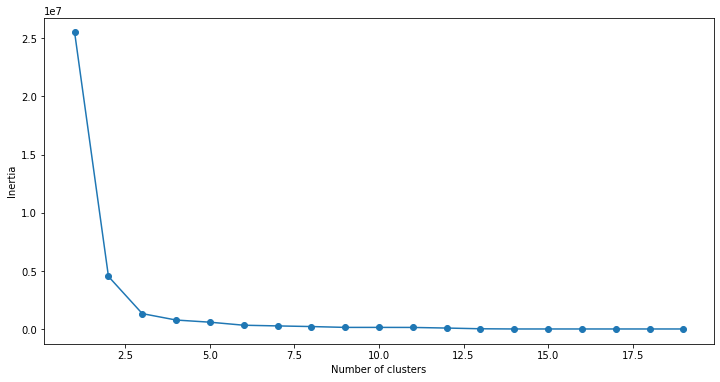

In [0]:
#sample 1kk, year
error = []
for clu in range(1, 20):
  km = KMeans(n_clusters=clu, init='random', n_init=10, max_iter=300, random_state=13, n_jobs=-1)
  km.fit(
      sample_train.iloc[:1000000, [6]]
      )
  error.append(km.inertia_)

frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':error})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

Text(0, 0.5, 'Inertia')

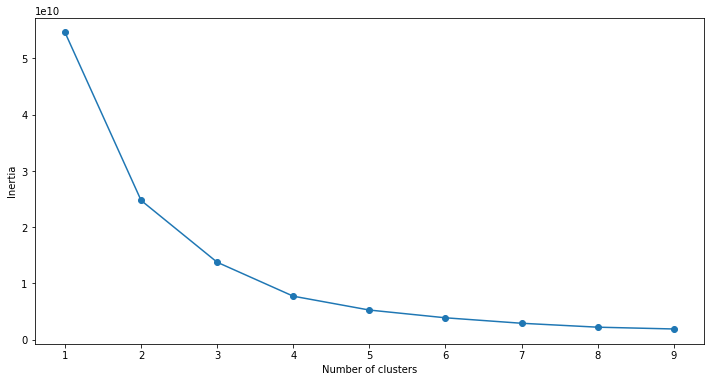

In [0]:
#sample 1kk, square
error = []
for clu in range(1, 10):
  km = KMeans(n_clusters=clu, init='random', n_init=5, max_iter=100, random_state=13, n_jobs=-1)
  km.fit(
       sample_year[sample_year.site_id == 15]
      )
  error.append(km.inertia_)

frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':error})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

#kNN

In [0]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [0]:
"""
default = 5 >> 0.97 wow


"""
knn = KNeighborsRegressor(n_neighbors=100, algorithm=)
X = sample_train.drop('meter_reading', axis = 1)
y = sample_train['meter_reading']   
knn.fit(X, y)
np.sqrt(mean_squared_log_error(y, np.clip(knn.predict(X), 0, None)))

In [0]:
X = sample_train.drop('meter_reading', axis = 1)
y = sample_train['meter_reading']  

In [0]:
Xx = X.iloc[:100000]
Yy = y.iloc[:100000]

In [0]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': -1,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [0]:
%%time
param = {'n_neighbors': [10, 15, 20],
         'weights': ('uniform', 'distance'),
         'p':[1,2],
         'algorithm': ('ball_tree', 'kd_tree', 'brute'),         
         }
knn = KNeighborsRegressor(n_jobs=-1)  
clf = GridSearchCV(knn, param)
clf.fit(Xx, Yy)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 1h 11min 53s, sys: 3min 9s, total: 1h 15min 2s
Wall time: 40min 50s


In [0]:
#:1000000
clf.best_params_, clf.best_score_

({'algorithm': 'ball_tree', 'n_neighbors': 15, 'p': 1, 'weights': 'distance'},
 0.23386762688103943)